## Stuff you can ignore. Scroll down

In [1]:
import numpy as np
from timeit import default_timer as timer
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.interpolate import UnivariateSpline

In [2]:
SMALL_SIZE = 13
MEDIUM_SIZE = 15
BIGGER_SIZE = 17

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.rcParams["savefig.bbox"] = 'tight'

# Thermodynamics Workshop

### Motivation:
This workshop is designed to show how different models of the Gibbs Free Energy can lead to different and interesting phase diagrams

### Structure of this workbook
We start with a very simple equation for the Gibbs free energy. 
There are then functions to minimize the free energy, and to plot a phase diagram over pressure and temperature.  

Finally, challenges are presented at the end. 


In [3]:
# Constants
Boltzmann_Constant = 8.617333262e-5 # eV / K / mol

### Gibbs free energy
The state of a substance in thermal equilibrium is the state that minimizes the Gibbs Free Energy. 

We begin with a simple two-state model, in which the atoms can form one of two states, A or B, in perfect solution.

It is based on this paper by Ackland *et al.*

https://journals.aps.org/prb/abstract/10.1103/PhysRevB.104.054120

We define the fraction of atoms in state A as
$$ x = \frac{N_A}{N_{TOT}} $$

In this initial simple model, the total Gibbs free energy is given as a linear combination of free energies from the two different states, solid and liquid, which have different free energies.

The liquid has a higher energy $U$ than the solid, but it also has a slightly higher entropy $S$, and it has a different equilibrium volume $V$. Thus, there are three key parameters to this model:
    
$~~~~~ \Delta U$ , representing the energy difference,
    
$~~~~~\Delta S$ , representing the entropy difference, and
    
$~~~~~\Delta V$ , representing a difference in preferred volumes between the two phases. 

The code below calculates the total Gibbs energy for a given fraction of solid to liquid, 
$$\gamma = \frac{N_{solid}}{N_{solid} + N_{liquid}}$$

$$ G_{total} = \gamma G_{solid} + (1-\gamma)G_{liquid} $$
$$ ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ = \gamma\left[0.0\right] + (1-\gamma)\left[\Delta U + P\Delta V - T\Delta S\right]$$

In [4]:
def Gibbs_Free_Energy(variables , args):
    """
    Calculates the Gibbs Free Energy for a given fraction x of atoms in state 'A' relative to total system
    
    arguments:
        variables : 
            gamma , the fraction melted
            V     , the volume of the system
    
        args , a list of other arguments. 
                at the moment, just temperature and pressure, but add more as needed
        
        settings : where delta_U , delta_S, and delta_V are set
        
    returns:
        Gibbs Free Energy for the specific value of x. eV / mol
    """
    
    # variables
    gamma = variables[0]
    V     = variables[1]
    
    # Arguments
    args[0] = T # temperature in Kelvin
    args[1] = P
    
    # Settings
    delta_U = 0.1   # eV/atom
    delta_S = 20.0*Boltzmann_Constant   # eV/K/atom
    delta_V = 0.0   # A^3 / atom
    
    # Contributing terms
    G_solid = 0.0
    
    G_liquid = ( delta_U + P*delta_V - T*delta_S  )    
    
    # -----------------------
    G_total = gamma*G_solid  +  (1. - gamma)*G_liquid  +  P*V
    
    return G_total

    

### Minimizing the Gibbs Free energy

The following function minimizes the Gibbs free energy *G* over $x$, the fraction of atoms in state A . 

In [5]:
def minimize_Gibbs(args):
    """
    Repeat the minimization several times from different starting values of x : {0, 1}
    AND for different starting values of V
    This is important, because the shape of G(x,V) may be quite complex, and have multiple minima. 
    At the moment, just starts from x = 0, 1/2, and 1. 
    and V start from 0.01 , 0.6, 1.0, and 1.5
    
    NOTE: if you drastically change the arguments of the Vinet equations-of-state, 
    you may need to significantly change the starting initial values, and the 'bounds' argument to the minimize function. 
    
    arguments: 
        args, a list of values needed for calculating the Gibbs Free Energy
    """
    
    x_initial_values = [0.5 , 1e-3, 1.0-1e-3]
    V_initial_values = [ 0.01 , 0.6 , 1.0, 1.5 ]
    
    answer = minimize( Gibbs_Free_Energy , 
                      [x_initial_values[0], V_initial_values[0]], 
                      args=args , 
                      tol=1e-10, 
                      bounds=[(1e-12, 1.0-1e-12), (1e-8, 1e5)])
    
    for x_init in x_initial_values :
        for v_init in V_initial_values :
            attempt = minimize( Gibbs_Free_Energy , 
                               [x_init, v_init], 
                               args=args, 
                               tol=1e-10, 
                               bounds=[(1e-12, 1.0-1e-12), (1e-8, 1e5)])
            if attempt.fun < answer.fun:
                answer = attempt
    
    return answer

## Pressure and Temperature phase diagram

The below code is designed to create diagrams of Gibbs free energy, and of the value of $x$ which minimizes the Gibbs free energy, for different values of pressure and temperature

In [6]:
pressure_list    = np.logspace(-3, 5, 20)  # creates 10 pressures between 1e-5 GPa and 100 GPa
temperature_list = np.linspace(0.0, 200, 15)  # array of 10 temperatures between 10 K and 1000 K. 



In [7]:


Gibbs_minimum_values = np.zeros((len(temperature_list), len(pressure_list)))
gamma_minimum_values = np.zeros((len(temperature_list), len(pressure_list)))
V_minimum_values     = np.zeros((len(temperature_list), len(pressure_list)))


start = timer()
for i, T in enumerate(temperature_list):
    for j, P in enumerate(pressure_list):
        
        args = [ T, P ]
        
        answer = minimize_Gibbs( args )
        
        Gibbs_minimum_values[i,j] = answer.fun
        gamma_minimum_values[i,j] = answer.x[0]      
        V_minimum_values[i,j]     = answer.x[1]      
        
    if i > 0:
        print("Estimated time to completion: {} s".format( (timer() - start) / i * len(temperature_list)  ),  end='\r' )
    

# Plot of $\gamma$ as a function of P and T

Text(0, 0.5, '$\\gamma$')

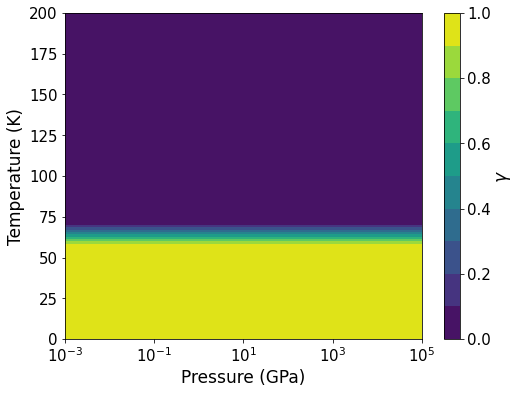

In [8]:
fig2, ax2 = plt.subplots(figsize=(8,6))

cs = ax2.contourf( pressure_list , temperature_list , gamma_minimum_values , levels=np.linspace(0.0, 1.0, 11), vmin=0.0, vmax=1.0)
ax2.set_xscale('log')
ax2.set_xlabel('Pressure (GPa)')
ax2.set_ylabel('Temperature (K)')

# Plots the actual calculated datapoints
#ax2.scatter( np.broadcast_to(pressure_list, Gibbs_minimum_values.shape).flatten() ,  np.broadcast_to(temperature_list, Gibbs_minimum_values.shape).T.flatten() )

cbar=fig2.colorbar(cs)
cbar.ax.set_ylabel('$\gamma$')

# Plot of the Gibbs Free Energy as a function of P and T
Purpose of this plot is simply to check that the Gibbs Free Energy changes continuously. 
Kinks are permissable, but there shouldn't be any discontinuous jumps in the Free Energy  (note, latent heat is not the same as a jump in the Free energy)

In [9]:
fig1, ax1 = plt.subplots(figsize=(8,6))

cs = ax1.contourf( pressure_list , temperature_list , Gibbs_minimum_values )
ax1.set_xscale('log')
ax1.set_xlabel('Pressure (GPa)')
ax1.set_ylabel('Temperature (K)')

# Plots the actual datapoints
#ax1.scatter( np.broadcast_to(pressure_list, Gibbs_minimum_values.shape).flatten() , np.broadcast_to(temperature_list, Gibbs_minimum_values.shape).T.flatten() )

cbar=fig1.colorbar(cs)
cbar.ax.set_ylabel('Gibbs Minimum Value (eV)')

Text(0, 0.5, 'Gibbs Minimum Value (eV)')

# Questions:

1(a) Do the phase diagrams you have plotted make any sense at all?

1(b) What kind of transitions, if any, are you seeing? 

1(c) Is there a critical point? 

# Part 2: Mixing terms

We now consider another simple system: where there are two kinds of atoms, A and B, which have different contributions to the Gibbs free energy. However, there is now also a mixing term which represents the entropy of mixing the two states. 

$$ G_{tot} = x G_A  + (1-x)G_B + k_BT\left[x\ln(x) + (1-x)\ln(1-x)\right], $$

where $G_A$ and $G_B$ are initially treated as constants, $k_B$ is the Boltzmann constant, and $T$ is the temperature. 

In [10]:
def Gibbs_Free_Energy(x , args):
    """
    Calculates the Gibbs Free Energy for a given fraction x of atoms in state 'A' relative to total system
    
    arguments:
        x , the fraction of atoms in state A
        args , a list of all the other arguments. 
                at the moment, just temperature, but add more as needed
    
    returns:
        Gibbs Free Energy for the specific value of x. eV / mol
    """
       
    # Arguments
    args[0] = T # temperature in Kelvin
      
    # Contributing terms
    G_A = 1.0
    
    G_B = 1.0
    
    G_mixing = Boltzmann_Constant*T*(x * np.log(x) + (1.-x)*np.log(1.-x))
    
    
    # -----------------------
    G_total = x*G_A + (1-x)*G_B + G_mixing
    
    return G_total

    

### Minimizing the Gibbs Free energy

The following function minimizes the Gibbs free energy *G* over $x$, the fraction of atoms in state A . 

In [11]:
def minimize_Gibbs(args):
    """
    Repeat the minimization several times from different starting values of x : {0, 1}
    This is important, because the shape of G(x) may be quite complex, and have multiple minima. 
    At the moment, just starts from x = 0, 1/2, and 1.     
    
    arguments: 
        args, a list of values needed for calculating the Gibbs Free Energy
    """
    
    x_initial_values = [0.5 , 1e-3, 1.0-1e-3]
    
    answer = minimize( Gibbs_Free_Energy , 
                      [x_initial_values[0]], 
                      args=args , 
                      tol=1e-10, 
                      bounds=[(1e-12, 1.0-1e-12)])
    
    for x_init in x_initial_values[1:] :
        attempt = minimize( Gibbs_Free_Energy , 
                           [x_init], 
                           args=args, 
                           tol=1e-10, 
                           bounds=[(1e-12, 1.0-1e-12)])
        if attempt.fun < answer.fun:
            answer = attempt
    return answer
    
    

## Pressure and Temperature phase diagram

The below code is designed to create diagrams of Gibbs free energy, and of the value of $x$ which minimizes the Gibbs free energy, for different values of pressure and temperature

In [12]:
pressure_list    = np.logspace(-5, 2, 10)  # creates 10 pressures between 1e-5 GPa and 100 GPa
temperature_list = np.linspace(0.0, 500, 10)  # array of 10 temperatures between 10 K and 1000 K. 



In [13]:
Gibbs_minimum_values = np.zeros((len(temperature_list), len(pressure_list)))
x_minimum_values     = np.zeros((len(temperature_list), len(pressure_list)))

start = timer()
for i, T in enumerate(temperature_list):
    for j, P in enumerate(pressure_list):
        
        args = [ T, P ]
        
        answer = minimize_Gibbs( args )
        
        Gibbs_minimum_values[i,j] = answer.fun
        x_minimum_values[i,j]     = answer.x      
        
    if i > 0:
        print("Estimated time to completion: {} s".format( (timer() - start) / i * len(temperature_list)  ),  end='\r' )
    

# Plot of $x$ as a function of P and T

In [14]:
fig2, ax2 = plt.subplots(figsize=(8,6))

cs = ax2.contourf( pressure_list , temperature_list , x_minimum_values , levels=np.linspace(0.0, 1.0, 11), vmin=0.0, vmax=1.0)
ax2.set_xscale('log')
ax2.set_xlabel('Pressure (GPa)')
ax2.set_ylabel('Temperature (K)')

# Plots the actual calculated datapoints
#ax2.scatter( np.broadcast_to(pressure_list, Gibbs_minimum_values.shape).flatten() ,  np.broadcast_to(temperature_list, Gibbs_minimum_values.shape).T.flatten() )

cbar=fig2.colorbar(cs)
cbar.ax.set_ylabel('x')

Text(0, 0.5, 'x')

# Questions 2:

2(a) Do the phase diagrams you have plotted make any sense at all given the form of $G$ ?

2(b) How, and why, do the phase diagrams differ if you change the contributing terms to $G$ to
$$ G_A = x*1.02   ~~~~~ , ~~~~~ G_B = (1-x)*1.0 $$ 
?

# Part 3: adding equations of state

## Rose-Vinet equation of state

The Rose-Vinet equation of state is an empirical equation relating volume to the Helmholtz Free Energy.

It is most commonly used in its derivative form - which just relates volume and pressure. 

However, we can imagine the two states A and B as each individually having relationships between their contribution to the free energy --- $G_A$ & $G_B$, respectively --- and the volume per atom $V$. 

The Vinet equation of state has four parameters: 
    
    E0 (a constant shift of free energy),
    
    V0 ( the volume of lowest free energy ),
    
    B0 (bulk modulus, parameterises how fast the free energy rises as the volume decreases),
    
    B_prime (a measure of how the compressibility changes as volume changes)

In [15]:
def rose_vinet_free_energy(V, E0 , V0 , B0 , B_prime):
    """
    arguments:
        E0 in eV    
        V0 in Angstrom^3 / atom
        B0 in GPa
        Bp dimensionless
    returns:
        the Helmholtz free energy from the Rose-Vinet equation of state in eV
    """
    eta = (V/V0)**(1./3.)
    B0 /= 160.21766208 # change units to eV / A^3
    
    return 4*B0*V0/(B_prime - 1.0)/(B_prime - 1.0) + 2*B0*V0/((B_prime - 1.0)*(B_prime - 1.0)) * np.exp( 1.5*(B_prime - 1.0)*(1.-eta) )  * (3*(B_prime - 1.0)*(1.-eta) - 2.)   + E0

### Plot of Vinet eos
This shows a plot of how the Rose-Vinet equation of state relates free energy to volume for a given set of parameters. 

Try playing around with the parameters E0, V0, B0, and B_prime and see how it changes the plot. 

In [16]:
dummy_volumes = np.linspace(0.4, 1.2, 100)
dummy_rv_free_energy_A = rose_vinet_free_energy( dummy_volumes , E0=0.0005,  V0=0.9,  B0=1.0,  B_prime=4.0)
dummy_rv_free_energy_B = rose_vinet_free_energy( dummy_volumes , E0=0.0,  V0=1.0,  B0=1.0,  B_prime=4.0)


plt.plot(dummy_volumes, dummy_rv_free_energy_A, label='G_A')
plt.plot(dummy_volumes, dummy_rv_free_energy_B, label='G_B')

plt.xlabel('Volume')
plt.ylabel('Free Energy')
plt.title('Free energy vs volume for Rose-Vinet eos')
plt.legend()

# Challenge 3:

See what happens if the contributing terms $G_A$ and $G_B$ have the following volume dependence given by the Rose-Vinet equation of state:

$$ G_A = x *  G_{Vinet}\left[V, E_0 = 0.0005 , V_0=0.9, B_0=100.0, B_{prime}=4.0 \right]  $$

$$ G_B = (1-x) * G_{Vinet}\left[V, E_0 = 0.0 , V_0=1.0, B_0 = 100.0, B_{prime}=4.0 \right]  $$

and we include the mixing term from before, and also we must include the $PV$ term:

$$ G_{total} = G_A + G_B + G_{mix} + PV $$



In [17]:
def Gibbs_Free_Energy( variables , args ):
    """
    Calculates the Gibbs Free Energy for a given fraction x of atoms in state 'A' relative to total system
    
    arguments:
        x , the fraction of atoms in state A
        V , the volume per atom
        args , a list of all the other arguments. 
                at the moment, just temperature, but add more as needed
    
    returns:
        Gibbs Free Energy for the specific value of x. eV / mol
    """
       
    # Arguments
    T = args[0]  # temperature in Kelvin
    P = args[1] 
    #args[3] = J
    
    # Variables
    x = variables[0]
    V = variables[1]
    
    # Contributing terms
    G_A = x * rose_vinet_free_energy(V, E0=0.0005 , V0=0.9 , B0=100.0 , B_prime=4.0) # CHANGE THIS IF YOU LIKE
    
    G_B = (1. - x) * rose_vinet_free_energy(V, E0=0.0 , V0=1.0 , B0=100.0 , B_prime=4.0)  # CHANGE THIS IF YOU LIKE
    
    G_mixing = Boltzmann_Constant*T*(x * np.log(x) + (1.-x)*np.log(1.-x))
    
    
    # -----------------------
    G_total = G_A + G_B + G_mixing + P/160.21766208*V   # Note, added the PV term including conversion between GPa and eV/A^3. 
    
    return G_total

### Minimizing Gibbs Free Energy wrt $x$ AND $V$

Because we are now considering free energies which have a volume dependence, we must minimize wrt both volume and $x$. 

In [18]:
def minimize_Gibbs(args):
    """
    Repeat the minimization several times from different starting values of x : {0, 1}
    AND for different starting values of V
    This is important, because the shape of G(x,V) may be quite complex, and have multiple minima. 
    At the moment, just starts from x = 0, 1/2, and 1. 
    and V start from 0.01 , 0.6, 1.0, and 1.5
    
    NOTE: if you drastically change the arguments of the Vinet equations-of-state, 
    you may need to significantly change the starting initial values, and the 'bounds' argument to the minimize function. 
    
    arguments: 
        args, a list of values needed for calculating the Gibbs Free Energy
    """
    
    x_initial_values = [0.5 , 1e-3, 1.0-1e-3]
    V_initial_values = [ 0.01 , 0.6 , 1.0, 1.5 ]
    
    answer = minimize( Gibbs_Free_Energy , 
                      [x_initial_values[0], V_initial_values[0]], 
                      args=args , 
                      tol=1e-10, 
                      bounds=[(1e-12, 1.0-1e-12), (1e-8, 1e5)])
    
    for x_init in x_initial_values :
        for v_init in V_initial_values :
            attempt = minimize( Gibbs_Free_Energy , 
                               [x_init, v_init], 
                               args=args, 
                               tol=1e-10, 
                               bounds=[(1e-12, 1.0-1e-12), (1e-8, 1e5)])
            if attempt.fun < answer.fun:
                answer = attempt
    
    return answer

## Pressure and Temperature phase diagram

The below code is designed to create diagrams of Gibbs free energy, and of the value of $x$ which minimizes the Gibbs free energy, for different values of pressure and temperature

In [19]:
pressure_list    = np.logspace(-5, 2, 15)  # creates 10 pressures between 1e-5 GPa and 100 GPa
temperature_list = np.linspace(0.0, 30, 10)  # array of 10 temperatures between 10 K and 1000 K. 


In [20]:
Gibbs_minimum_values = np.zeros((len(temperature_list), len(pressure_list)))
x_minimum_values     = np.zeros((len(temperature_list), len(pressure_list)))
V_minimum_values     = np.zeros((len(temperature_list), len(pressure_list)))


start = timer()
for i, T in enumerate(temperature_list):
    for j, P in enumerate(pressure_list):
        
        args = [ T, P ]
        
        answer = minimize_Gibbs( args )
        
        Gibbs_minimum_values[i,j] = answer.fun
        x_minimum_values[i,j]     = answer.x[0]
        V_minimum_values[i,j]     = answer.x[1]
        
    if i > 0:
        print("Estimated time to completion: {:.0f} s                 ".format( (timer() - start) / i * (len(temperature_list)-i)  ),  end='\r' )
print('Finished                                                      ')

Finished                                                      


# Plot of the Gibbs Free Energy as a function of P and T
Purpose of this plot is simply to check that the Gibbs Free Energy changes continuously. 
Kinks are permissable, but there shouldn't be any discontinuous jumps in the Free Energy  (note, latent heat is not the same as a jump in the Free energy)

In [21]:
fig1, ax1 = plt.subplots(figsize=(8,6))

cs = ax1.contourf( pressure_list , temperature_list , Gibbs_minimum_values )
ax1.set_xscale('log')
ax1.set_xlabel('Pressure (GPa)')
ax1.set_ylabel('Temperature (K)')

# Plots the actual datapoints
#ax1.scatter( np.broadcast_to(pressure_list, Gibbs_minimum_values.shape).flatten() , np.broadcast_to(temperature_list, Gibbs_minimum_values.shape).T.flatten() )

cbar=fig1.colorbar(cs)
cbar.ax.set_ylabel('Gibbs Minimum Value (eV)')

Text(0, 0.5, 'Gibbs Minimum Value (eV)')

# Plot of $x$ as a function of P and T

In [22]:
fig2, ax2 = plt.subplots(figsize=(8,6))

cs = ax2.contourf( pressure_list , temperature_list , x_minimum_values , levels=np.linspace(0.0, 1.0, 11))
ax2.set_xscale('log')
ax2.set_xlabel('Pressure (GPa)')
ax2.set_ylabel('Temperature (K)')


cbar=fig2.colorbar(cs)
cbar.ax.set_ylabel('x')

Text(0, 0.5, 'x')

### Plot of the volume as a function of $P$ and $T$

In [23]:
fig3, ax3 = plt.subplots(figsize=(8,6))

cs = ax3.contourf( pressure_list , temperature_list , V_minimum_values, levels=21) #, levels=np.linspace(0.0, 1.0, 21), vmin=0.0, vmax=1.0)
ax3.set_xscale('log')
ax3.set_xlabel('Pressure (GPa)')
ax3.set_ylabel('Temperature (K)')

# Plots the actual calculated datapoints
#ax2.scatter( np.broadcast_to(pressure_list, Gibbs_minimum_values.shape).flatten() ,  np.broadcast_to(temperature_list, Gibbs_minimum_values.shape).T.flatten() )

cbar=fig3.colorbar(cs)
cbar.ax.set_ylabel('Volume (Å$^3$ / atom)')

Text(0, 0.5, 'Volume (Å$^3$ / atom)')

# Questions 3:

3(a). What is going on? Why does it look like this? (hint: consider the vinet equations of state plotted above)

3(b). What kind of phase transitions are there --- if any? 

3(c). How does it change if you change the Vinet equation of state parameters, defined in the function "Gibbs_Free_Energy"?

3(d). Can you alter the Vinet parameters and/or the temperature and pressure ranges to plot a phase diagram with a visible critical point? 

3(e). Can you change the equations of state in such a way as to make any phase-transition line not vertical? 
 

# Tool: Plot the Gibbs Free Energy at fixed $x$

To properly determine the order of a transition, sometimes it can be useful to plot the Free Energy with a certain fixed parameter --- e.g. the Gibbs Free energy for an (artificially) fixed $x$

The code below might be useful for this. minimize_gibbs_wrt_volume finds the smallest Gibbs Free Energy for a fixed $x$, $T$, and $P$.

In [24]:
def minimize_gibbs_wrt_volume(x, args):
    
    V_initial_values = [ 0.01 , 0.6 , 1.0, 1.5 ]
    
    answer=minimize( Gibbs_Free_Energy , 
                           [x, V_initial_values[0]], 
                           args=args, 
                           tol=1e-10, 
                           bounds=[(x-1e-12, x+1e-12), (1e-8, 1e5)])
    
    for v_init in V_initial_values[1:] :
        attempt = minimize( Gibbs_Free_Energy , 
                           [x, v_init], 
                           args=args, 
                           tol=1e-10, 
                           bounds=[(x-1e-12, x+1e-12), (1e-8, 1e5)])
        if attempt.fun < answer.fun:
            answer = attempt
    
    return answer

### Try messing with the settings for $P$ and $T$ below. 

In [25]:
P = 1.0   # GPa
T = 30.0  # Kelvin

x_values = np.linspace(1e-2, 1-1e-2, 50)
G_plot_values = np.zeros(x_values.shape)
V_plot_values = np.zeros(x_values.shape)

for i,x in enumerate(x_values):
    answer=minimize_gibbs_wrt_volume(x, [T,P])
    V_plot_values[i] = answer.x[1]
    G_plot_values[i] = answer.fun

plt.plot(x_values, G_plot_values)
plt.xlabel('$x$') 
plt.ylabel('Gibbs Free Energy at fixed $x$')

Text(0, 0.5, 'Gibbs Free Energy at fixed $x$')

# Task 4: Adding a Liquid Phase

We add liquid phases associated with each solid. 
A melted A-type liquid, 
and a melted B-type liquid

This means we now need three parameters to minimize over:
$x$ and $y$ which quantify the proportion of A-type atoms in the solid and liquid, respectively. And $\gamma$, which quantifies the degree of melting. 

$$ x = \frac{N_A^{solid}}{N_A^{solid} + N_B^{solid}},~~~~~~~y = \frac{N_A^{liquid}}{N_A^{liquid} + N_B^{liquid}}, ~~~~~~\gamma = \frac{N_{A}^{solid} + N_B^{solid}}{N_{total}},$$


Liquid phases are typically higher energy than their solid counterparts, but also have greater entropy. Thus, we relate the contributions to the free-energy from liquid-$A$ and liquid-$B$ using four constants: $\Delta U_A$, $\Delta S_A$, $\Delta U_B$, and $\Delta S_B$, representing the change in energy and entropy between the liquid and solids, respectively. 

Final subtlety: the liquid atoms can mix with each other, and the solid atoms can mix with each other, but the solids and liquids cannot mix meaningfully. As such, the contribution to the Gibbs free energy from mixing of atoms in state A and B, $G_{mixing}$, looks slightly more complex.  

In [26]:
def Gibbs_Free_Energy( variables , args ):
    """
    Calculates the Gibbs Free Energy for a given fraction x of atoms in state 'A' relative to total system
    
    arguments:
        variables
        x , the fraction of solid atoms in solid state A
        y , the fraction of atoms in solid state B
        z , the fraction of atoms in liquid state A
        1-x-y-z , the fraction of atoms in liquid state B
        V , the volume per atom
        
        args , a list of all the other arguments. 
                at the moment, just temperature, but add more as needed
    
    returns:
        Gibbs Free Energy for the specific value of x. eV / mol
    """

    # Variables
    x     = variables[0]
    y     = variables[1]
    gamma = variables[2]
    V     = variables[3]
    
    # Arguments
    T = args[0]  # temperature in Kelvin
    P = args[1]  # pressure in GPa
    
    # Settings
    delta_U_A = 0.1   # eV/atom
    delta_U_B = 0.1   # eV/atom
    delta_S_A = 100.0*Boltzmann_Constant    # eV/K/atom
    delta_S_B = 100.0*Boltzmann_Constant    # eV/K/atom
    
    # Contributing terms
    G_solid_A = rose_vinet_free_energy(V, 
                                       E0=0.0005 , 
                                       V0=0.9 , 
                                       B0=100.0 , 
                                       B_prime=4.0)
    G_liquid_A = rose_vinet_free_energy(V, 
                                        E0=0.0005 , 
                                        V0=0.9 , 
                                        B0=100.0 , 
                                        B_prime=4.0)  +  delta_U_A   - delta_S_A*T
    
    G_solid_B = rose_vinet_free_energy(V, 
                                       E0=0.0 , 
                                       V0=1.0 , 
                                       B0=100.0 , 
                                       B_prime=4.0)
    
    G_liquid_B = rose_vinet_free_energy(V, 
                                        E0=0.0 , 
                                        V0=1.0 , 
                                        B0=100.0 , 
                                        B_prime=4.0)   + delta_U_B  -delta_S_B*T
    
    
    G_mixing_A = Boltzmann_Constant*T*( (x)*np.log(x) + (1-x)*np.log(1-x) )
    G_mixing_B = Boltzmann_Constant*T*( (y)*np.log(y) + (1-y)*np.log(1-y) )
    G_mixing   = gamma*G_mixing_A + (1-gamma)*G_mixing_B
    
    # -----------------------
    G_total = gamma*x*G_solid_A + gamma*(1-x)*G_solid_B                   \
                + (1-gamma)*y*G_liquid_A + (1-gamma)*(1-y)*G_liquid_B     \
                + G_mixing + P/160.21766208*V   # Note, added the PV term including conversion between GPa and eV/A^3. 
    
    return G_total

In [27]:
def minimize_Gibbs(args):
    
    x_initial_values , gamma_initial_values = [0.5, 0.01, 0.99] , [0.5, 0.1, 0.9]
    V_initial_values = [ 0.1 , 0.6, 1.0 ]
    
    answer = minimize( Gibbs_Free_Energy , 
                      [0.25, 0.25, 0.25, V_initial_values[0]], 
                      args=args , 
                      tol=1e-10, 
                      bounds=[(1e-12, 1.0-1e-12), (1e-12, 1.0-1e-12), (1e-12, 1.0-1e-12), (1e-8, 1e5)])
    
    for x_init in x_initial_values :
        for gamma_init in gamma_initial_values :
            for v_init in V_initial_values :
                attempt = minimize( Gibbs_Free_Energy , 
                                   [x_init, x_init, gamma_init, v_init], 
                                   args=args, 
                                   tol=1e-10, 
                                   bounds=[(1e-12, 1.0-1e-12), (1e-12, 1.0-1e-12), (1e-12, 1.0-1e-12), (1e-8, 1e5)])
                if attempt.fun < answer.fun:
                    answer = attempt
    
    return answer


In [28]:
pressure_list    = np.logspace(-2, 4, 10)  # creates 10 pressures between 1e-5 GPa and 100 GPa
temperature_list = np.linspace(0.0, 100, 10)  # array of 10 temperatures between 10 K and 1000 K. 


In [29]:
Gibbs_minimum_values = np.zeros((len(temperature_list), len(pressure_list)))
x_minimum_values     = np.zeros((len(temperature_list), len(pressure_list)))
y_minimum_values     = np.zeros((len(temperature_list), len(pressure_list)))
gamma_minimum_values = np.zeros((len(temperature_list), len(pressure_list)))
V_minimum_values     = np.zeros((len(temperature_list), len(pressure_list)))


start = timer()
for i, T in enumerate(temperature_list):
    for j, P in enumerate(pressure_list):
        
        args = [ T, P ]
        
        answer = minimize_Gibbs( args )
        
        Gibbs_minimum_values[i,j] = answer.fun
        x_minimum_values[i,j]     = answer.x[0]
        y_minimum_values[i,j]     = answer.x[1]
        gamma_minimum_values[i,j] = answer.x[2]
        V_minimum_values[i,j]     = answer.x[3]
        
    if i > 0:
        print("Estimated time to completion: {:.0f} s                 ".format( (timer() - start) / i * (len(temperature_list)-i)  ),  end='\r' )
print('Finished                                                      ')

Finished                                                      


Text(0, 0.5, 'Portion of A-type atoms')

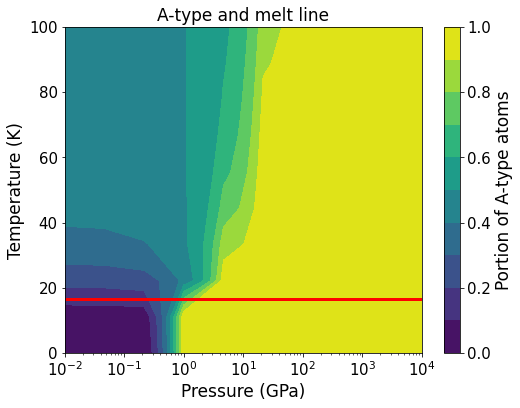

In [30]:
fig2, ax2 = plt.subplots(figsize=(8,6))

degree_of_A = gamma_minimum_values*x_minimum_values + (1.-gamma_minimum_values)*y_minimum_values

cs = ax2.contourf( pressure_list , temperature_list , degree_of_A , levels=np.linspace(0.0, 1.0, 11))
ax2.set_xscale('log')
ax2.set_xlabel('Pressure (GPa)')
ax2.set_ylabel('Temperature (K)')
ax2.set_title('A-type and melt line')
melt_line = ax2.contour(pressure_list, temperature_list, gamma_minimum_values, colors='red',linewidths=3, levels=[0.5])

cbar=fig2.colorbar(cs)
cbar.ax.set_ylabel('Portion of A-type atoms')

Text(0, 0.5, '$\\gamma$')

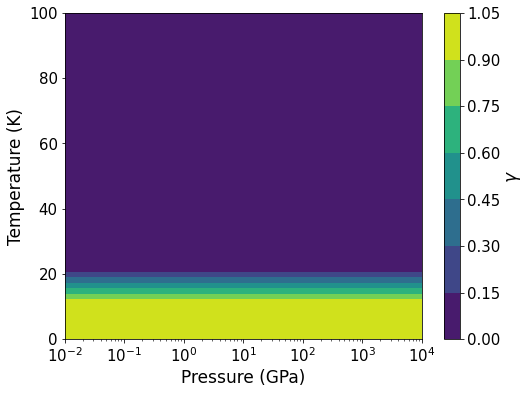

In [31]:
fig2, ax2 = plt.subplots(figsize=(8,6))

cs = ax2.contourf( pressure_list , temperature_list , gamma_minimum_values )
ax2.set_xscale('log')
ax2.set_xlabel('Pressure (GPa)')
ax2.set_ylabel('Temperature (K)')

cbar=fig2.colorbar(cs)
cbar.ax.set_ylabel('$\gamma$')

Text(0, 0.5, 'Volume')

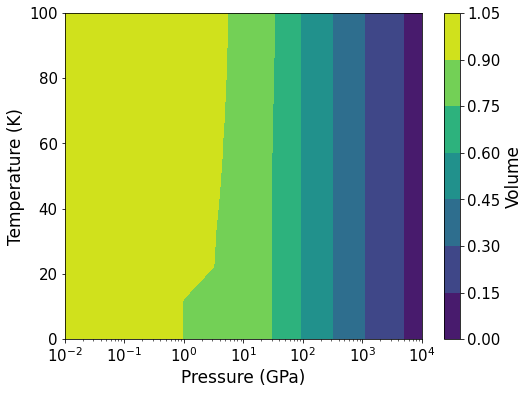

In [32]:
fig2, ax2 = plt.subplots(figsize=(8,6))

cs = ax2.contourf( pressure_list , temperature_list , V_minimum_values )
ax2.set_xscale('log')
ax2.set_xlabel('Pressure (GPa)')
ax2.set_ylabel('Temperature (K)')

cbar=fig2.colorbar(cs)
cbar.ax.set_ylabel('Volume')

# Questions 4:
4(a). What kind of transitions are happening? Describe the phase-diagram in words. 

4(b). Is there a critical point? 

4(c). Can you manipulate the parameters defined in Gibbs_Free_Energy (both delta_U etc., and the equation-of-state parameters), in order to make the melt line not be horizontal? 

4(d). Can you make the critical point go below the melt line? 

4(e). Can you make the critical point disappear below T=0 ? 

# Tool: Second Derivatives of the Free Energy $G(T,P)$

Second derivatives of the Free Energy are often what is measured practically in experiment. If a differentiable functional form for $G$ is known, then this can be plotted easily, but the code below calculates second derivatives numerically. 

## Isothermal compressibility
The standard thermodynamic definitions of isothermal compressibility is:
$$ \kappa_T = -\frac{1}{V}\left(\frac{\partial V}{\partial P}\right)_T = -\frac{1}{V}\left(\frac{\partial^2G}{\partial P^2}\right)_{T},  $$

In [33]:
# List of pressures and temperatures. 
temperature = 25 # Kelvin

n_points = 100
pressure_list     = np.linspace(0.0, 5.0, n_points)
free_energy_list , volume_list , x_list  = np.zeros(n_points) , np.zeros(n_points) , np.zeros(n_points)


for i, P in enumerate(pressure_list):
    answer = minimize_Gibbs( [ temperature , P ] )
    
    free_energy_list[i] = answer.fun
    x_list[i]           = answer.x[0]
    volume_list[i]      = answer.x[1]

(Text(0.5, 0, 'Pressure (GPa)'), Text(0, 0.5, '$\\kappa_T$ (GPa$^-1$)'))

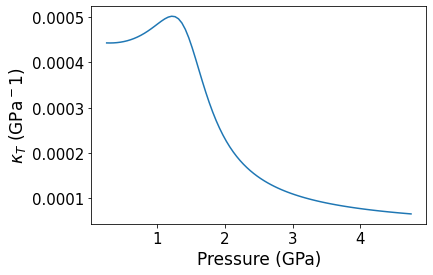

In [34]:
# Create a spline interpolation of the free energy as a function of pressure. 
free_energy_interpolation  = UnivariateSpline( pressure_list , free_energy_list , k=5, s=0 )

# Differentiate the spline 
isothermal_compressibility = -1./volume_list * free_energy_interpolation.derivative(2)(pressure_list)

# Plot
plt.plot(pressure_list[5:-5] , isothermal_compressibility[5:-5])
plt.xlabel('Pressure (GPa)') , plt.ylabel('$\kappa_T$ (GPa$^-1$)')

## Isobaric Heat Capacity

The isobaric heat capacity $C_P$ is typically defined as:
$$ C_P = -T\left(\frac{\partial^2 G}{\partial T^2}\right)_P $$

In [49]:
# List of pressures and temperatures. 
pressure = 0.8 # GPa

n_points = 100
temperature_list     = np.linspace(0.0, 100.0, n_points)
free_energy_list , volume_list , x_list  = np.zeros(n_points) , np.zeros(n_points) , np.zeros(n_points)

start = timer()
for i, T in enumerate(temperature_list):
    answer = minimize_Gibbs( [ T , pressure ] )
    
    free_energy_list[i] = answer.fun
    x_list[i]           = answer.x[0]
    volume_list[i]      = answer.x[1]
    
    if i > 0:
        print('Expected time to completion {:.0f} s         '.format((timer()-start)/i*(len(temperature_list)-i)), end='\r')
        
print('Finished                                                                             ')

Finished                                                                             


(Text(0.5, 0, 'Temperature (K)'), Text(0, 0.5, '$C_P$ (eV / K / atom)'))

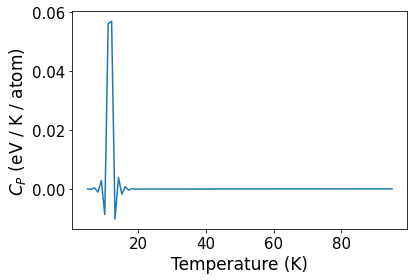

In [50]:
# Create a spline interpolation of the free energy as a function of pressure. 
free_energy_interpolation  = UnivariateSpline( temperature_list , free_energy_list , k=5, s=0 )

# Differentiate the spline 
isobaric_heat_capacity = -temperature_list * free_energy_interpolation.derivative(2)(temperature_list)

# Plot
plt.plot(temperature_list[5:-5] , isobaric_heat_capacity[5:-5])
plt.xlabel('Temperature (K)') , plt.ylabel('$C_P$ (eV / K / atom)')

# Task 4: Add a seperation term. 

Many substances prefer not to be perfectly mixed. Indeed, in many cases, different states would rather seperate their phases in space. In other words, mixed states have an energy penalty. 

We can model this by adding a term to the free energy:

$$ G_{seperate} = J*x*(1-x) $$

So the total free energy becomes:
$$ G_{total} = xG_A + (1-x)G_B + Jx(1-x) + G_{mix} + PV $$


The minimize_Gibbs functions function can remain the same.

3(a) Replot the phase diagrams. How does it differ? 

3(b) Can you make a critical point appear? 

3(c) What kind of phase-transitions happen (e.g. first order, 2nd order, continuous, none)?